In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph 
from copy import deepcopy
import pickle
from plot_module import plot_neuron_graph

In [2]:
nodetype_dict = {1:'soma', 2:'axon', 3:'dendrite', 4:'dendrite'}
color_dict = {1:'red', 2:'blue', 3:'limegreen', 4:'limegreen'}

In [24]:
name = 'h_neocortex_interneuron_NMO_97216'
file = f'neuron_shape_data/{name}.txt'
full_swc_df = pd.read_csv(file, sep = ' ', header=None, skipinitialspace = True)
full_swc_df.columns = ['comp_id','type','x','y','z','radius','parent_id']
full_swc_df

,comp_id,type,x,y,z,radius,parent_id
0,1,1,0.00,0.00,0.00,6.809,-1
1,4,3,0.92,3.75,-0.44,0.345,1
2,5,3,2.67,5.02,0.67,0.285,4
3,6,3,7.17,9.01,-0.44,0.230,5
4,7,3,9.49,11.57,-0.44,0.230,6
...,...,...,...,...,...,...,...
2321,2324,2,22.91,-26.74,-3.44,0.035,2323
2322,2325,2,22.55,-27.12,-3.44,0.035,2324
2323,2326,2,22.32,-27.16,-3.44,0.035,2325
2324,2327,2,20.97,-28.16,-3.99,0.035,2326


In [15]:
# distance between two points
def edge_length(input_df, node_id, parent_id):
    node_row = input_df.loc[input_df['comp_id'] == node_id]
    parent_row = input_df.loc[input_df['comp_id'] == parent_id]
    
    node_xyz = np.array([node_row['x'], node_row['y'], node_row['z']]).flatten()
    parent_xyz = np.array([parent_row['x'], parent_row['y'], parent_row['z']]).flatten()
    
    # 3d euclidean distance
    return np.round(np.linalg.norm(node_xyz-parent_xyz), 4)

# approximate the volume of an edge using a cylinder (produces identical results to neuromorpho)
def edge_volume(input_df, node_id, parent_id):
    node_row = input_df.loc[input_df['comp_id'] == node_id]
    parent_row = input_df.loc[input_df['comp_id'] == parent_id]
    
    node_xyz = np.array([node_row['x'], node_row['y'], node_row['z']]).flatten()
    parent_xyz = np.array([parent_row['x'], parent_row['y'], parent_row['z']]).flatten()
    
    # volume of cylinder
    h = np.linalg.norm(node_xyz-parent_xyz)
    r = float(node_row['radius'])
    return np.round(np.pi*r*r*h, 4)
    
def volume_by_type(G):
    edge_volumes_and_types = ([(e[2]['volume'], int(e[2]['edgetype'])) for e in G.edges(data=True)])
    
    soma_volume = (4/3)*np.power(list(G.nodes(data = True))[0][1]['radius'], 3)*np.pi
    axon_volume = np.sum([element[0] for element in edge_volumes_and_types if element[1] == 2])
    dendrite_volume = np.sum([element[0] for element in edge_volumes_and_types if element[1] != 2])
    
    absolute_volumes = np.array([soma_volume, axon_volume, dendrite_volume]).round(2)
    relative_volumes = np.round(absolute_volumes/np.sum(absolute_volumes), 2)

    print('absolute volumes (s, a, d)', absolute_volumes)
    print('relative volumes (s, a, d)', relative_volumes)

In [16]:
def nxgraph_from_swc_df(swc_df):
    G = nx.Graph()
    
    # add nodes
    for index, row in swc_df.iterrows():
        G.add_node(
            str(int(row['comp_id'])), 
            nodetype = int(row['type']), 
            radius = float(row['radius']),
            xy = (float(row['x']), float(row['y']))
        )
    
    # add edges
    for index, row in swc_df.iterrows():
        if index > 0:
            G.add_edge(
                str(int(row['comp_id'])), str(int(row['parent_id'])), 
                volume = edge_volume(swc_df, int(row['comp_id']), int(row['parent_id'])),
                len = edge_length(swc_df, int(row['comp_id']), int(row['parent_id'])),
                edgetype = int(row['type'])      
            )
    
    return G

In [17]:
neuron_graph_full = nxgraph_from_swc_df(full_swc_df)
volume_by_type(neuron_graph_full)

absolute volumes (s, a, d) [1322.33   24.68  493.44]
relative volumes (s, a, d) [0.72 0.01 0.27]


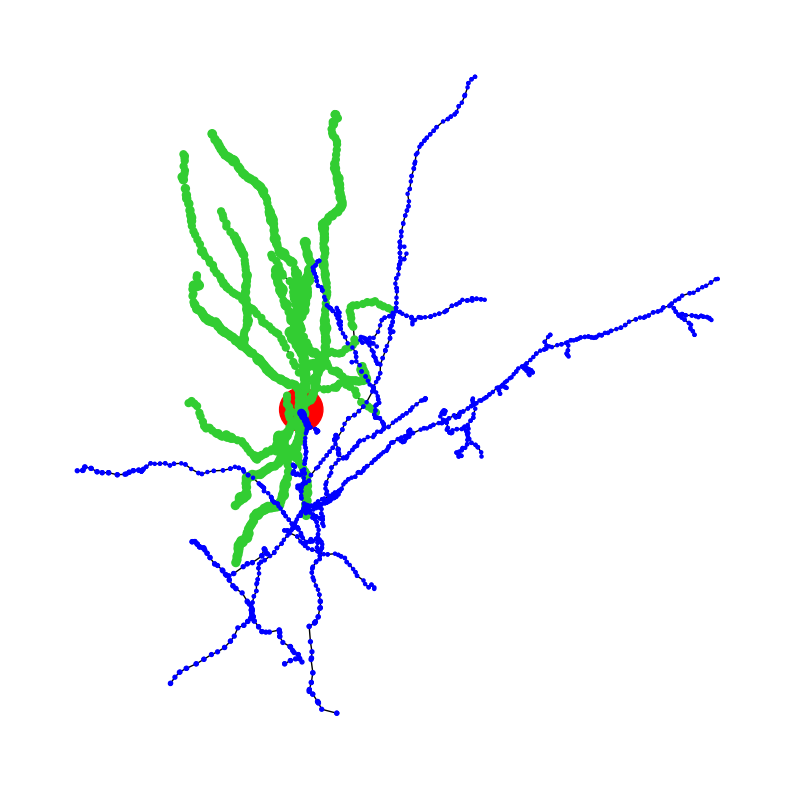

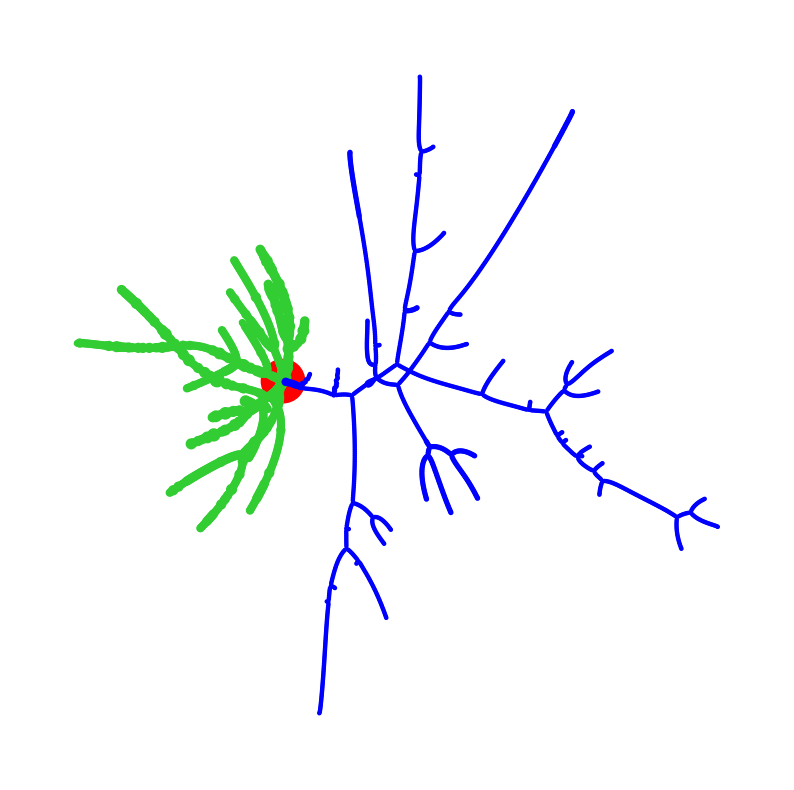

In [18]:
plot_neuron_graph(neuron_graph_full)

In [19]:
def remove_transition_nodes(G, swc_df):
    out_df = deepcopy(swc_df)

    # find leaf, root, and branch nodes
    leaf_nodes = [x for x in G.nodes() if G.degree(x)==1]
    root_node = [leaf_nodes[0]]; leaf_nodes = leaf_nodes[1:]
    branch_nodes = [x for x in G.nodes() if len(nx.descendants_at_distance(G, x, 1)) > 2]

    # find remaining nodes, which are transitions.
    transition_nodes = list(set(G.nodes()) - set(leaf_nodes) - set(root_node) - set(branch_nodes))
    
    # go through the graph, removing the transition nodes
    for tran_node_id in transition_nodes:
        
        tran_node_row = out_df.loc[out_df['comp_id'] == int(tran_node_id)]
        prnt_node_id = int(tran_node_row['parent_id'])
        
        prnt_node_row = out_df.loc[out_df['comp_id'] == prnt_node_id]
        chld_node_row = out_df.loc[out_df['parent_id'] == int(tran_node_id)]

        # rewrite parent of child node to parent of transition node
        out_df.loc[chld_node_row.index, 'parent_id'] = prnt_node_id

        # delete the row corresponding to the node
        out_df = out_df.drop(tran_node_row.index)
            
    
    return out_df

In [20]:
filtered_swc_df = remove_transition_nodes(neuron_graph_full, full_swc_df)
filtered_swc_df

,comp_id,type,x,y,z,radius,parent_id
0,1,1,0.00,0.00,0.00,6.809,-1
10,13,3,19.54,27.75,-0.44,0.170,1
43,46,3,81.38,45.65,-12.89,0.115,13
55,58,3,26.53,53.69,-2.76,0.400,13
158,161,3,44.52,364.97,-6.53,0.115,58
...,...,...,...,...,...,...,...
2286,2289,2,250.05,135.84,8.39,0.035,2253
2288,2291,2,151.57,105.50,-4.73,0.035,2253
2290,2293,2,125.24,96.35,-12.02,0.035,2137
2311,2314,2,-11.14,-68.14,6.75,0.035,887


In [21]:
neuron_graph_filtered = nxgraph_from_swc_df(filtered_swc_df)
volume_by_type(neuron_graph_filtered)

absolute volumes (s, a, d) [1322.33   21.43  418.09]
relative volumes (s, a, d) [0.75 0.01 0.24]


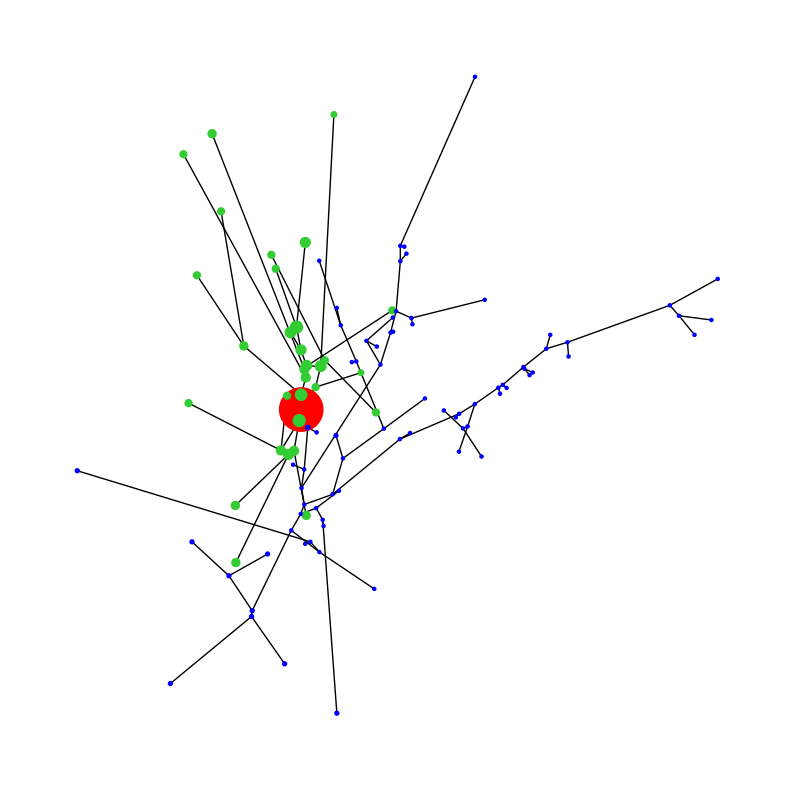

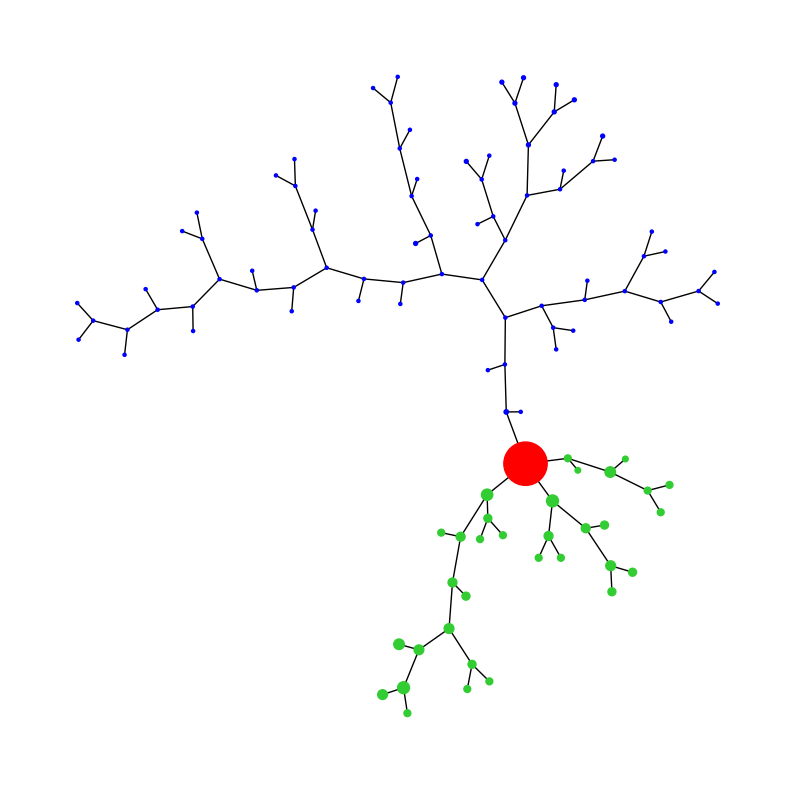

In [22]:
plot_neuron_graph(neuron_graph_filtered)

In [25]:
# with open(f'neuron_shape_data/{name}.pkl', 'wb') as f:
#     pickle.dump(neuron_graph_filtered, f)